첫번째 프로젝트의 진행에서 KNN모델과 랜덤포레스트 모델들을 이용하여 머신러닝을 진행하였습니다.

다만 정확도가 계속해서 좋지 못해서 새로운 데이터 셋으로 진행을 하였습니다.

이전 데이터 셋에서는 정수인코딩을 이용하여 데이터셋을 정리 하였습니다.

이번에는 원핫인코딩(더미인코딩)을 이용하여 데이터셋을 정리할 것입니다.

In [143]:
import re
import sys

import time
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

%matplotlib inline

In [144]:
# Loading the data
#df = pd.read_csv('../input/googleplaystore.csv')
#df = pd.read_csv('drive/My Drive/Colab Notebooks/google_play_app_rating/googleplaystore.csv')
df = pd.read_csv('googleplaystore.csv')

In [145]:
sns.set(style='darkgrid')
sns.set_palette('PuBuGn_d')

# Data Exploration and Cleaning

In [146]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


App               False
Category          False
Rating             True
Reviews           False
Size              False
Installs          False
Type               True
Price             False
Content Rating     True
Genres            False
Last Updated      False
Current Ver        True
Android Ver        True
dtype: bool

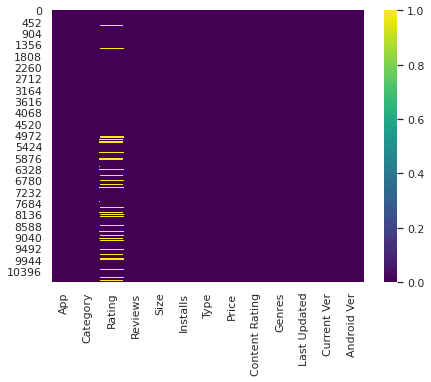

In [148]:
# Exploring missing data and checking if any has NaN values
plt.figure(figsize=(7, 5))
sns.heatmap(df.isnull(), cmap='viridis')
df.isnull().any()

In [149]:
df.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

이전 데이터셋 비어있는 데이터들을 삭제 하였으나 이번 데이터셋에서는 중간값을 비어있는 곳에 넣어줍니다.

또한 비어있는 값들을 채우기전에 문자 혹은 특수문자로 되어있는 데이터들을 정리합니다.

In [150]:
# The best way to fill missing values might be using the median instead of mean.
df['Rating'] = df['Rating'].fillna(df['Rating'].median())

# Before filling null values we have to clean all non numerical values & unicode charachters 
replaces = [u'\u00AE', u'\u2013', u'\u00C3', u'\u00E3', u'\u00B3', '[', ']', "'"]
for i in replaces:
	df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : x.replace(i, ''))

regex = [r'[-+|/:/;(_)@]', r'\s+', r'[A-Za-z]+']
for j in regex:
	df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : re.sub(j, '0', x))

df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : x.replace('.', ',',1).replace('.', '').replace(',', '.',1)).astype(float)
df['Current Ver'] = df['Current Ver'].fillna(df['Current Ver'].median())

문자형 변수인 카테고리에 어떠한 변수들이 있는지 확인합니다.

In [151]:
df['Category'].unique()

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
       'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
       'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
       'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION',
       '1.9'], dtype=object)

카테고리 내에서 1.9라는 특이한 변수가 있습니다
1.9에 대한 부분만 따로 출력합니다.

In [152]:
# Check the record  of unreasonable value which is 1.9
i = df[df['Category'] == '1.9'].index
df.loc[i]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0,NaN


이 데이터의 경우 맨처음인 앱 이름의 값이 비어있어서 데이터의 값들이 앞으로 당겨진것같습니다.

현재 App에 있는 값은 Category로 현재 Category에있는 1.9는 Rating으로 가는 것이 올바른 것으로 보이며 뒤에있는 칼럼들도 마찬가지 입니다.

이를 일일히 수정하는 것은 힘드므로 Category = 1.9에 대한 부분을 제거합니다.


In [153]:
df = df.drop(i)

추가적으로 Last Updated와 Content Rating에 있는 NaN값을 제거해줍니다.

In [154]:
df = df[pd.notnull(df['Last Updated'])]
df = df[pd.notnull(df['Content Rating'])]

# Categorical Data Encoding

이제 범주형 변수를 숫자로 바꾸어줍시다.

In [155]:
# App values encoding
le = preprocessing.LabelEncoder()
df['App'] = le.fit_transform(df['App'])
# This encoder converts the values into numeric values

In [156]:
# Category features encoding
category_list = df['Category'].unique().tolist() 
category_list = ['cat_' + word for word in category_list]
df = pd.concat([df, pd.get_dummies(df['Category'], prefix='cat')], axis=1)

In [157]:
# Genres features encoding
le = preprocessing.LabelEncoder()
df['Genres'] = le.fit_transform(df['Genres'])

In [158]:
# Encode Content Rating features
le = preprocessing.LabelEncoder()
df['Content Rating'] = le.fit_transform(df['Content Rating'])

In [159]:
# Price cealning
df['Price'] = df['Price'].apply(lambda x : x.strip('$'))

In [160]:
# Installs cealning
df['Installs'] = df['Installs'].apply(lambda x : x.strip('+').replace(',', ''))

In [161]:
# Type encoding
df['Type'] = pd.get_dummies(df['Type'])

In [162]:
# Last Updated encoding
df['Last Updated'] = df['Last Updated'].apply(lambda x : time.mktime(datetime.datetime.strptime(x, '%B %d, %Y').timetuple()))

In [163]:
# Convert kbytes to Mbytes 
k_indices = df['Size'].loc[df['Size'].str.contains('k')].index.tolist()
converter = pd.DataFrame(df.loc[k_indices, 'Size'].apply(lambda x: x.strip('k')).astype(float).apply(lambda x: x / 1024).apply(lambda x: round(x, 3)).astype(str))
df.loc[k_indices,'Size'] = converter

In [164]:
# Size cleaning
df['Size'] = df['Size'].apply(lambda x: x.strip('M'))
df[df['Size'] == 'Varies with device'] = 0
df['Size'] = df['Size'].astype(float)

이제 데이터 정리를 완료하였습니다.

다음은 머신러닝입니다.

# Machine Learning

머신 러닝 시작이전에 x와 y에 값을 넣어줍니다.

그리고 학습 데이터와 테스트 테이들을 분리해줍니다.

In [165]:
# Split data into training and testing sets
features = ['App', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver']
features.extend(category_list)
X = df[features]
y = df['Rating']

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 10)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

# K-Nearest Neighbors Model

In [167]:
# Look at the 15 closest neighbors
model = KNeighborsRegressor(n_neighbors=15)

In [168]:
# Find the mean accuracy of knn regression using X_test and y_test
model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                    weights='uniform')

In [169]:
# Calculate the mean accuracy of the KNN model
accuracy = model.score(X_test,y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

'Accuracy: 92.22%'

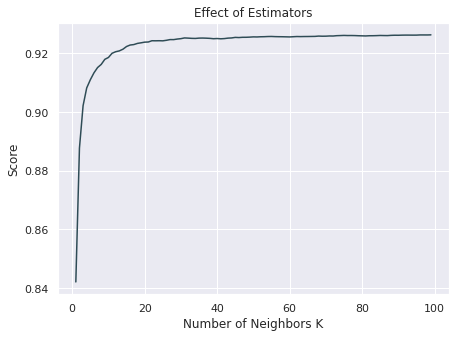

In [170]:
# Try different numbers of n_estimators - this will take a minute or so
n_neighbors = np.arange(1, 100, 1)
scores = []
for n in n_neighbors:
    model.set_params(n_neighbors=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
    Results = model.predict(X_test)
plt.figure(figsize=(7, 5))
plt.title("Effect of Estimators")
plt.xlabel("Number of Neighbors K")
plt.ylabel("Score")
plt.plot(n_neighbors, scores)

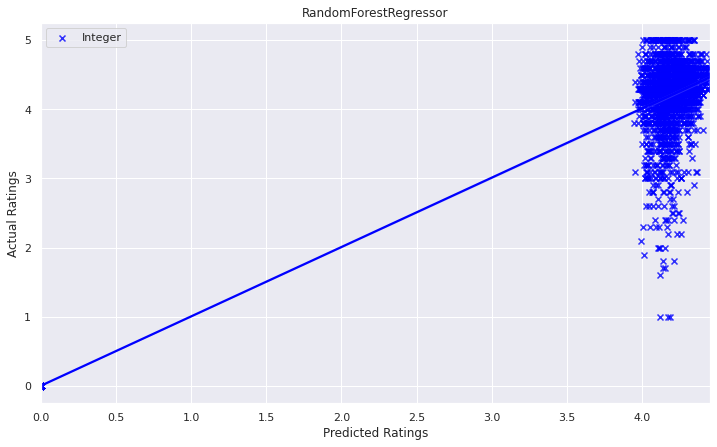

In [171]:
plt.figure(figsize=(12,7))
sns.regplot(Results,y_test,color='blue', label = 'Integer', marker = 'x')
plt.legend()
plt.title('RandomForestRegressor')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

In [172]:
predictions = model.predict(X_test)
'Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions)

('Mean Absolute Error:', 0.27786760594878673)

In [173]:
'Mean Squared Error:', metrics.mean_squared_error(y_test, predictions)

('Mean Squared Error:', 0.19255599530283637)

In [174]:
'Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions))

('Root Mean Squared Error:', 0.4388120272996587)

# Random Forest Model

[(10, 0.9288525436349159),
 (20, 0.9357313453637982),
 (30, 0.9348191699011198),
 (40, 0.9375161291012343),
 (50, 0.9369647539176738),
 (60, 0.9375428698774516),
 (70, 0.9374324862095987),
 (80, 0.9372677030122166),
 (90, 0.9371787676821778),
 (100, 0.9383154799330647),
 (110, 0.9383889743650695),
 (120, 0.938303774428987),
 (130, 0.9382823430082515),
 (140, 0.9382175643994733),
 (150, 0.9379173542891343),
 (160, 0.9382145686943564),
 (170, 0.9380730818711775),
 (180, 0.9383599276540286),
 (190, 0.9380799309358245)]

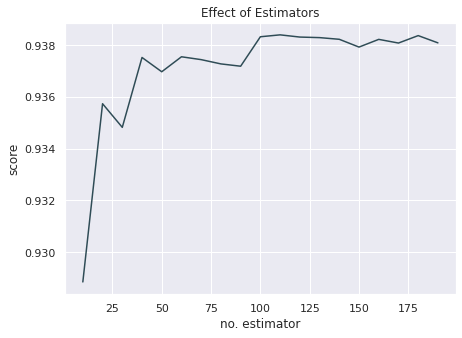

In [175]:
model = RandomForestRegressor(n_jobs=-1)
# Try different numbers of n_estimators - this will take a minute or so
estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
    Results = model.predict(X_test)
plt.figure(figsize=(7, 5))
plt.title("Effect of Estimators")
plt.xlabel("no. estimator")
plt.ylabel("score")
plt.plot(estimators, scores)
results = list(zip(estimators,scores))
results

In [176]:
# Calculate the mean accuracy of the KNN model
accuracy = model.score(X_test,y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

'Accuracy: 93.81%'

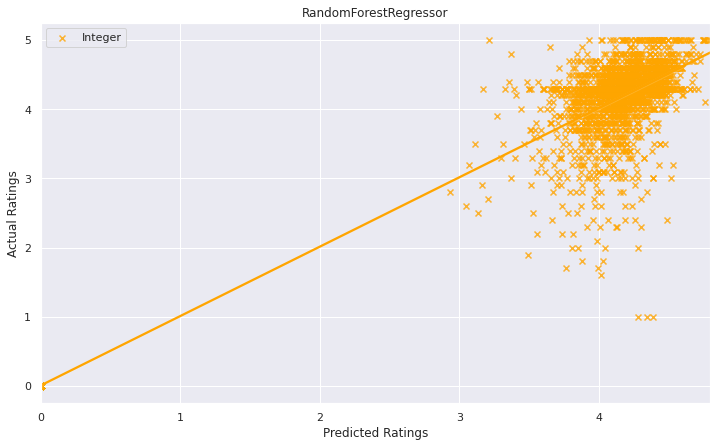

In [177]:
plt.figure(figsize=(12,7))
sns.regplot(Results,y_test,color='orange', label = 'Integer', marker = 'x')
plt.legend()
plt.title('RandomForestRegressor')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

In [178]:
predictions = model.predict(X_test)
'Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions)

('Mean Absolute Error:', 0.24258457953000603)

In [179]:
'Mean Squared Error:', metrics.mean_squared_error(y_test, predictions)

('Mean Squared Error:', 0.16156636403593952)

In [180]:
'Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions))

('Root Mean Squared Error:', 0.40195318637366156)